### Connection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from graphdatascience import GraphDataScience

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

### Preprocessing on db
Delete movies without ratings

In [2]:
gds.run_cypher(
    """
    MATCH (m:Movie)
    WHERE NOT ()-[:RATED]->(m)
    DETACH DELETE m
    """
)

""


# Exploratory analysis

![image.png](images/db_schema_start.png)  

This is a tripartite graph with users that rated movies that belong to genres.  
The graph is directional, without cycles, with one weighted (`RATED`) and one unweighted (`BELONGS`) edge.  
It is sparse, because there is ~10 k nodes and 1M edges (|edge|<100M).   

The analysis will be divided into:
- Analysing the various distributions in the data
- Connectivity analysis (global and local)
- Create some other properties and relations to add informaton to the graph


### Analysing the various distributions in the data

#### Users property distribution
From these graphs it can be seen that the majority of users are young, in particular many are in the 25-34 bracket.  
The most frequent occupation is collage or managerial. There is a large segment who did not want to specify their occupation.  
Finally, most users define themselves as male.

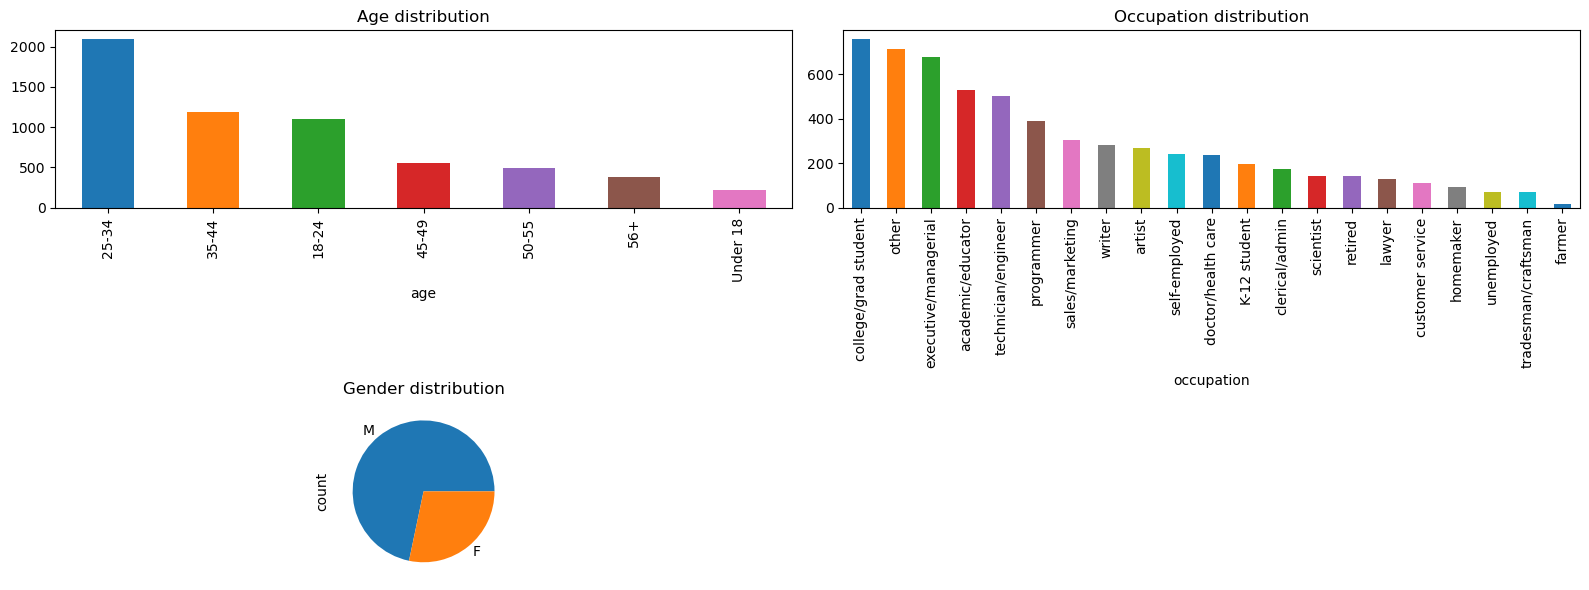

In [3]:
from helpers import AGE_LABELS, OCCUPATION_LABELS
from matplotlib.colors import TABLEAU_COLORS

users = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.gender as gender,u.age as age,u.occupation as occupation;
    """
)

fig, ax = plt.subplots(2, 2, figsize=(16, 6))

users_age = users["age"].value_counts()
users_age = users_age.rename(index=AGE_LABELS)
users_age.plot(kind="bar", color=TABLEAU_COLORS, title="Age distribution", ax=ax[0, 0])

users_occupation = users["occupation"].value_counts()
users_occupation = users_occupation.rename(index=OCCUPATION_LABELS)
users_occupation.plot(
    kind="bar", color=TABLEAU_COLORS, title="Occupation distribution", ax=ax[0, 1]
)
users["gender"].value_counts().plot(
    kind="pie", title="Gender distribution", ax=ax[1, 0]
)

fig.delaxes(ax[1, 1])
fig.tight_layout()

#### Distribution of films over the years
It can be seen that most of the films are from the 1990s and 2000s, but there are historical films even made in the 1920s.

<Axes: >

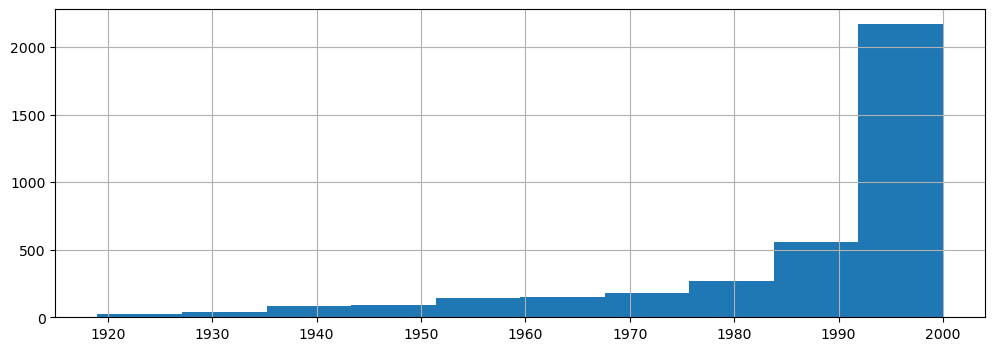

In [4]:
movies = gds.run_cypher(
    """
    MATCH (m:Movie)
    RETURN m.title as title,m.year as year;
    """
)
movies["year"].hist(figsize=(12, 4))

#### Distribution movies grouped in genres
It can be seen from the graph that most films belong to the drama and comedy.

<Axes: xlabel='genre'>

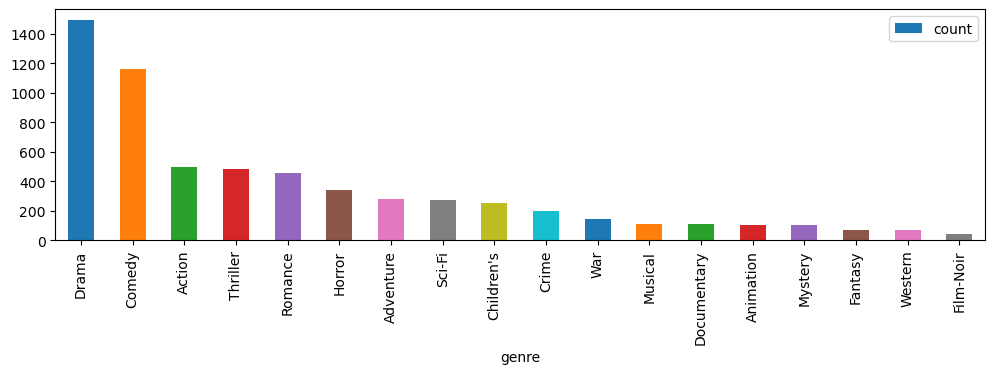

In [5]:
movies_per_genre_distributions = gds.run_cypher(
    """
    MATCH (m:Movie)-[:BELONGS]->(g:Genre)
    RETURN g.name as genre, COUNT(m) as count
    ORDER BY count DESC;
"""
)
movies_per_genre_distributions.plot(
    kind="bar", x="genre", y="count", color=TABLEAU_COLORS, figsize=(12, 3)
)

#### Distribution of the most liked genres
The result of this cell gives us the ranking of the genres with the highest average number of reviews.  
In the graph below, the bars are ordered according to this average.  
We note that films in the film-noir, documentary and war genres had very positive ratings, but they are also poorly reviewed and probably niche films.  
Especially film-noir is the genre with the fewest films within the dataset.  

This is a very superficial evaluation, but we understand that the network may have several communities.

,genre,count,avg_rating
0,Film-Noir,18261,4.075188
1,Documentary,7910,3.933123
2,War,68527,3.893327
3,Drama,354529,3.766332
4,Crime,79541,3.708679
5,Animation,43293,3.684868
6,Mystery,40178,3.668102
7,Musical,41533,3.665519
8,Western,20683,3.637770
9,Romance,147523,3.607465


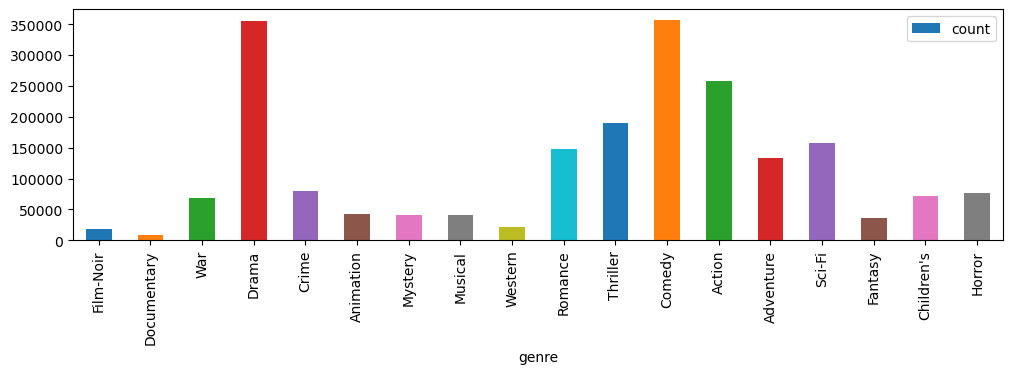

In [6]:
most_liked_genre_distribution = gds.run_cypher(
    """
    MATCH ()-[r:RATED]->(:Movie)-[:BELONGS]->(g:Genre)
    RETURN g.name as genre, COUNT(r) as count, AVG(r.rating) as avg_rating
    ORDER BY avg_rating DESC;
"""
)
most_liked_genre_distribution.plot(
    kind="bar", x="genre", y="count", color=TABLEAU_COLORS, figsize=(12, 3)
)
most_liked_genre_distribution

#### Distribution of ratings given in reviews
We can see that most of the votes given are 4 and in general there are positive votes.

<Axes: xlabel='rating'>

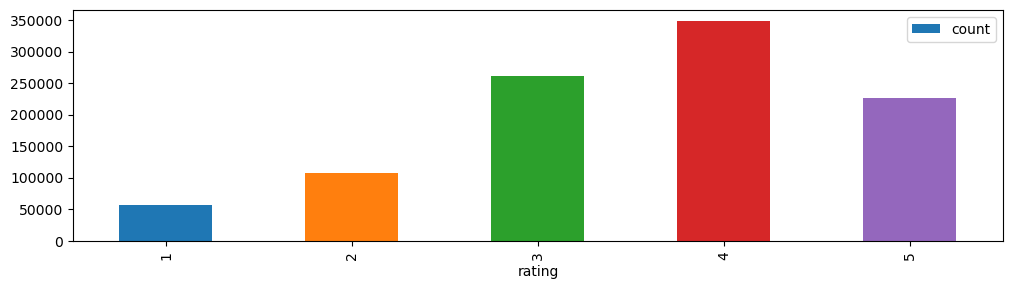

In [7]:
ratings_vote_distribution = gds.run_cypher(
    """
    MATCH (u:User)-[r:RATED]->(m:Movie)
    RETURN r.rating as rating, COUNT(*) as count
    ORDER BY rating;
    """
)
ratings_vote_distribution.plot(
    kind="bar", x="rating", y="count", color=TABLEAU_COLORS, figsize=(12, 3)
)

#### Annual ratings distributions
Almost all reviews were made in the year 2000

<Axes: xlabel='year'>

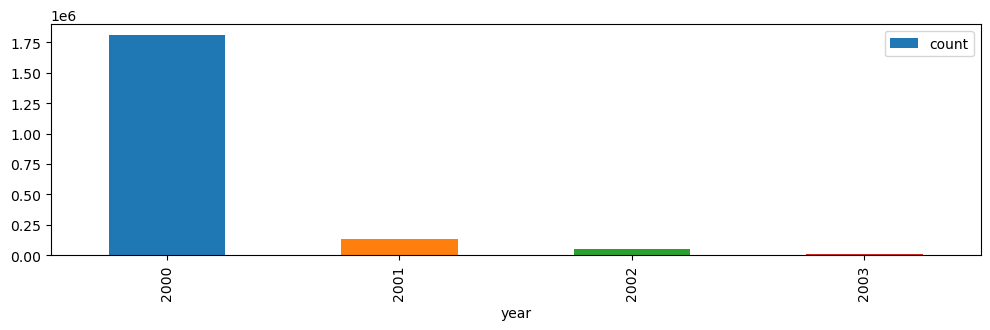

In [8]:
annual_ratings_distribution = gds.run_cypher(
    """
    MATCH ()-[r:RATED]-()
    RETURN r.year as year, COUNT(*) as count
    ORDER BY year;

"""
)
annual_ratings_distribution.plot(
    kind="bar", x="year", y="count", color=TABLEAU_COLORS, figsize=(12, 3)
)

#### Monthly ratings distributions
The periods when more people vote and consequently we assume more films are watched are November and December.  
Also in the summer period there is an increase in reviews during July and August.

<Axes: xlabel='month'>

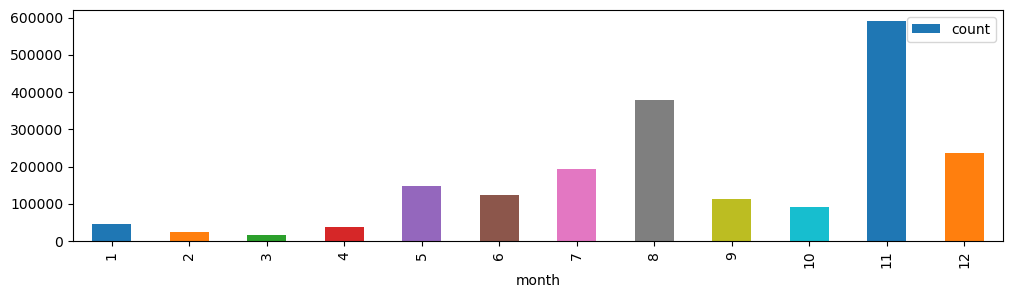

In [9]:
monthly_ratings_distribution = gds.run_cypher(
    """
    MATCH ()-[r:RATED]-()
    RETURN r.month as month, COUNT(*) as count
    ORDER BY month;

"""
)
monthly_ratings_distribution.plot(
    kind="bar", x="month", y="count", color=TABLEAU_COLORS, figsize=(12, 3)
)

## Connectivity Analysis
In this section we try to understand the structure of the network based on its connections.  
We will consider the complete network for general analysis, but will focus mainly on the bipartite users-movies graph

#### Creation graph projections

In [12]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-full',
    ['User', 'Movie', 'Genre'],
    ['RATED', 'BELONGS']
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-full,"{'User': {'label': 'User', 'properties': {}}, ...",9764,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",1006401


In [13]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'users-rates',
    ['Movie','User'],
    {
        RATED:{properties:['rating','month','year']}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)

### Global connectivity
The graph structure is a single, weakly connected block, as can be seen from the result in the cell below. 

In [14]:
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("movies-full")
    YIELD componentCount
    """
).componentCount[0]
print(f"In general graph there's {result} weakly connected component.")
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("users-rates")
    YIELD componentCount
    """
).componentCount[0]
print(f"And also in users-rates graph there's {result} weakly connected component.")

In general graph there's 1 weakly connected component.
And also in users-rates graph there's 1 weakly connected component.


### Local connectivity

#### Density
The graph was chosen on the grouplens site because of its good density and at the same time not a huge number of relations to allow the analysis to be computed in a non-long time.  


In [15]:
result = gds.run_cypher(
    """
    CALL gds.graph.list('movies-full')
    YIELD density,degreeDistribution
"""
)
print(f"Density: {result['density'][0]}")
print(f"Degree distribution: {result['degreeDistribution'][0]}")

Density: 0.010557473490004797
Degree distribution: {'min': 0, 'max': 2314, 'p90': 297, 'p999': 1286, 'p99': 828, 'p50': 37, 'p75': 125, 'p95': 446, 'mean': 103.07261368291684}


#### Write degree properties on users and movies nodes

In [16]:
gds.run_cypher(
    """CALL gds.degree.write('users-rates', {writeProperty: 'outDegree' })"""
)
gds.run_cypher(
    """CALL gds.degree.write('users-rates', {orientation:'REVERSE', writeProperty: 'inDegree' })"""
)

gds.run_cypher(
    """
    MATCH (u:User)
    SET u.ratings = toInteger(u.outDegree)
    REMOVE u.inDegree, u.outDegree;
    """
)

gds.run_cypher(
    """
    MATCH (m:Movie)
    SET m.ratings = toInteger(m.inDegree)
    REMOVE m.inDegree, m.outDegree;
    """
)

""


#### Top 10 movies with the most reviews

In [26]:
gds.run_cypher(
    """
    MATCH (m:Movie)
    RETURN m.title AS title, m.ratings AS ratings
    ORDER BY ratings DESC, title  DESC
    LIMIT 10
"""
)

,title,ratings
0,American Beauty (1999),3428
1,Star Wars: Episode IV - A New Hope (1977),2991
2,Star Wars: Episode V - The Empire Strikes Back...,2990
3,Star Wars: Episode VI - Return of the Jedi (1983),2883
4,Jurassic Park (1993),2672
5,Saving Private Ryan (1998),2653
6,Terminator 2: Judgment Day (1991),2649
7,Matrix The (1999),2590
8,Back to the Future (1985),2583
9,Silence of the Lambs The (1991),2578


#### Top 10 users with the most reviews

In [27]:
result = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.userId as id,u.gender AS gender, u.age AS age, u.occupation AS occupation, u.ratings AS ratings
    ORDER BY ratings DESC
    LIMIT 10
"""
)
result["age"] = result["age"].map(AGE_LABELS)
result["occupation"] = result["occupation"].map(OCCUPATION_LABELS)
result

,id,gender,age,occupation,ratings
0,4169,M,50-55,other,2314
1,1680,M,25-34,writer,1850
2,4277,M,35-44,self-employed,1743
3,1941,M,35-44,technician/engineer,1595
4,1181,M,35-44,executive/managerial,1521
5,889,M,45-49,writer,1518
6,3618,M,56+,technician/engineer,1344
7,2063,M,25-34,college/grad student,1323
8,1150,F,25-34,writer,1302
9,1015,M,35-44,clerical/admin,1286


#### Movies in degree distribution
Analyzing the degree distribution of the nodes, we can say that the distribution behaves like that of pareto.  
So a small proportion of films are reviewed by most of the network (80/20 rule).

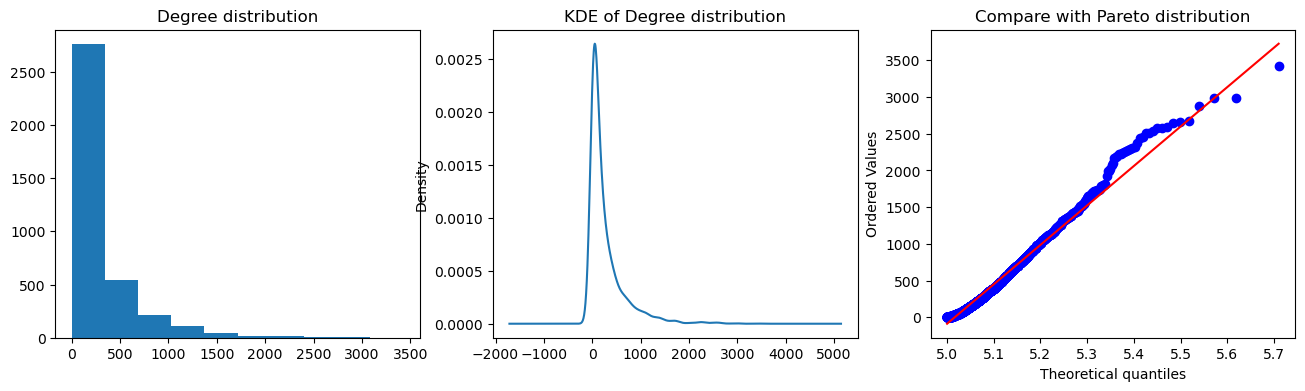

The centrality of the distribution is given by its median 123.5


count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: ratings, dtype: float64

In [17]:
result = gds.run_cypher(
    """
    MATCH (m:Movie)
    RETURN m.title as title,m.ratings as ratings
    ORDER BY ratings DESC
    """
)
movies_degree = result["ratings"]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(movies_degree, bins=10)
ax[0].set_title("Degree distribution")
movies_degree.plot.kde(ax=ax[1])
ax[1].set_title("KDE of Degree distribution")
stats.probplot(movies_degree, dist="pareto", sparams=(16, 4), plot=ax[2])
ax[2].set_title("Compare with Pareto distribution")
plt.show()
print(
    f"The centrality of the distribution is given by its median {movies_degree.median()}"
)
movies_degree.describe()

#### Users out degree distribution
Analyzing the degree distribution of the nodes, we can say that the distribution behaves like that of pareto.  
So a small proportion of users do most of the reviews on the network (80/20 rule)

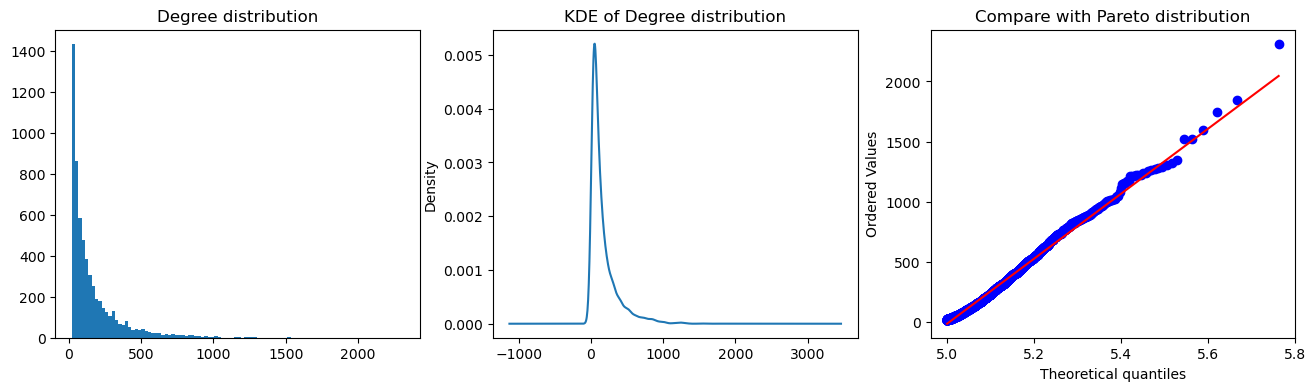

The centrality of the distribution is given by its median 96.0


count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: ratings, dtype: float64

In [18]:
result = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.title as title,u.ratings as ratings
    ORDER BY ratings DESC
    """
)
users_degree = result["ratings"]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(users_degree, bins=100)
ax[0].set_title("Degree distribution")
users_degree.plot.kde(ax=ax[1])
ax[1].set_title("KDE of Degree distribution")
stats.probplot(users_degree, dist="pareto", sparams=(16, 4), plot=ax[2])
ax[2].set_title("Compare with Pareto distribution")
plt.show()
print(
    f"The centrality of the distribution is given by its median {users_degree.median()}"
)
users_degree.describe()

#### Box plot Users vs Movies distributions
Viewing the box plots also confirms that the distribution has a lot of dispersion and many possible outliers.  
They cannot be ignored, but what we will do is categorise them according to activity so as to consider this aspect of the network during the similarity analysis

Text(0.5, 1.0, 'Boxplot of Users degree distribution')

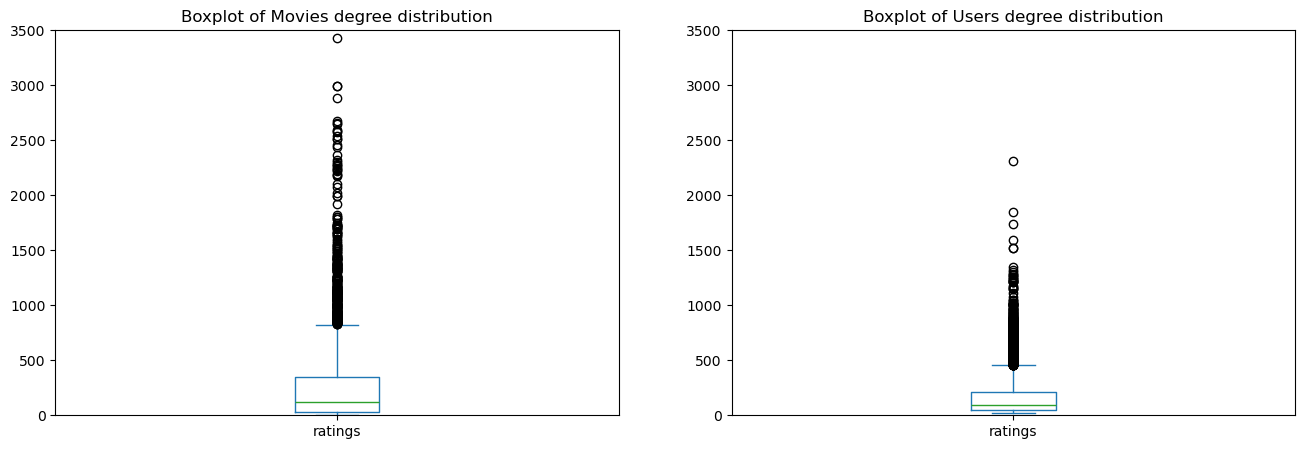

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
movies_degree.plot.box(ax=ax[0], ylim=(0, 3500))
ax[0].set_title("Boxplot of Movies degree distribution")
users_degree.plot.box(ax=ax[1], ylim=(0, 3500))
ax[1].set_title("Boxplot of Users degree distribution")

## Adding information on the network
With the aim of improving the analysis, efforts were made to add extra information in the nodes and relationships so that this information could be used to better calculate the similarity of the nodes.  
The added attributes are categorical in order to be evaluated by Neo4j's algorithm using Jaccard Similarity.    
They have been converted into numbers because Neo4j does not yet allow the calculation of similarity on categorical attributes of type string.

### Activity categories to user
A new categorical attribute was added to classify user activity in the platform.  
The categorization was based on the previously calculated distribution and then divided into 10-tiles to have ranges correlated with it

In [20]:
gds.run_cypher(
    f"""
    MATCH (u:User)
    WITH u,
    CASE u.ratings
        WHEN <{users_degree.quantile(0.10)} THEN 1
        WHEN <{users_degree.quantile(0.20)} THEN 2
        WHEN <{users_degree.quantile(0.30)} THEN 3
        WHEN <{users_degree.quantile(0.40)} THEN 4
        WHEN <{users_degree.quantile(0.50)} THEN 5
        WHEN <{users_degree.quantile(0.60)} THEN 6
        WHEN <{users_degree.quantile(0.70)} THEN 7
        WHEN <{users_degree.quantile(0.80)} THEN 8
        WHEN <{users_degree.quantile(0.90)} THEN 9
        ELSE 10
    END AS activity
    SET u.activity = activity
    RETURN DISTINCT activity, COUNT(*) AS count
    ORDER BY activity;
    """
)

,activity,count
0,1,553
1,2,652
2,3,588
3,4,616
4,5,610
5,6,592
6,7,614
7,8,600
8,9,610
9,10,605


### Popularity categories to movies nodes
An attribute to measure the popularity of the film within the network based on reviews (both positive and negative).  

The categorization was based on the previously calculated distribution and then divided into 10-tiles to have ranges correlated with it

In [21]:
gds.run_cypher(
    f"""
    MATCH (m:Movie)
    WITH m,
    CASE m.ratings
        WHEN <{movies_degree.quantile(0.10)} THEN 1
        WHEN <{movies_degree.quantile(0.20)} THEN 2
        WHEN <{movies_degree.quantile(0.30)} THEN 3
        WHEN <{movies_degree.quantile(0.40)} THEN 4
        WHEN <{movies_degree.quantile(0.50)} THEN 5
        WHEN <{movies_degree.quantile(0.60)} THEN 6
        WHEN <{movies_degree.quantile(0.70)} THEN 7
        WHEN <{movies_degree.quantile(0.80)} THEN 8
        WHEN <{movies_degree.quantile(0.90)} THEN 9
        ELSE 10
    END AS popularity
    SET m.popularity = popularity
    RETURN DISTINCT popularity, COUNT(*) AS count
    ORDER BY popularity;
    """
)

,popularity,count
0,1,356
1,2,374
2,3,377
3,4,365
4,5,381
5,6,368
6,7,372
7,8,370
8,9,372
9,10,371


### Add User LIKE genre relationship
A relationship linking users with genders.   
By doing some tests, it was seen that similarity and community detection worked best with a not too high value of links between user and gender. (5 was the parameter chosen).   

The score attribute is a non-normalised value expressing the amount of pleasure based on the user's activity, i.e. the number of reviews made.  
This value has the problem of being highly influenced by the type of user who has the link.  
In similarity, it was decided to consider this unweighted arc because it was seen to have better results.  
(The score attribute remains for possible future use).


In [22]:
gds.run_cypher(
    """
    MATCH (u:User) 
    WITH u.userId AS userId
    CALL {
        WITH userId
        MATCH (u:User WHERE u.userId = userId)-[r:RATED]->(:Movie)-[:BELONGS]->(g:Genre) 
        RETURN g.genreId AS genreId, AVG(r.rating) AS avg_rating
        ORDER BY avg_rating DESC
        LIMIT 5
    }
    MATCH (u:User WHERE u.userId = userId)
    MATCH (g:Genre WHERE g.genreId = genreId)
    MERGE (u)-[l:LIKES]->(g)
    SET l.score = round(avg_rating,2)
    """
)

""


### Favorite month to watch movies
 
When is the month when a user watch more movies?  
It is added this information foreach users, in this way in similarity analysis the algorithm helps to find users with same routines.  

In [23]:
gds.run_cypher(
    """
    MATCH (u:User) 
    WITH u.userId AS userId
    CALL {
        WITH userId
        MATCH (u:User WHERE u.userId = userId)-[r:RATED WHERE r.rating>3]->(:Movie) 
        RETURN r.month as month,COUNT(*) AS count
        ORDER BY count DESC
        LIMIT 1
    }
    MATCH (u:User WHERE u.userId = userId)
    SET u.favoriteMonth = month
    RETURN userId, month, count
    """
)

,userId,month,count
0,1,12,34
1,2,12,73
2,3,12,37
3,4,12,18
4,5,12,82
...,...,...,...
6033,6036,4,399
6034,6037,4,120
6035,6038,4,13
6036,6039,4,90


### Favorite month when see this movie
Same things about movie, which is the month with the most frequently of ratings to a specific movie?  
In this way we have more information about the film and maybe found more precise correlations between movies.

In [28]:
gds.run_cypher(
    """
    MATCH (m:Movie) 
    WITH m.movieId AS movieId
    CALL {
        WITH movieId
        MATCH (:User)-[r:RATED WHERE r.rating>3]->(m:Movie WHERE m.movieId = movieId) 
        RETURN r.month as month,COUNT(*) AS count
        ORDER BY count DESC
        LIMIT 1
    }
    MATCH (m:Movie WHERE m.movieId = movieId)
    SET m.favoriteMonth = toInteger(month)
    RETURN movieId, month, count
    """
)

,movieId,month,count
0,1,11,512
1,2,11,71
2,3,11,65
3,4,7,7
4,5,11,31
...,...,...,...
3528,3948,11,252
3529,3949,11,73
3530,3950,11,6
3531,3951,11,14


### Transform gender in number to evaluate it 
This transformation was useful for consider gender information on Neo4j's similarity algorithm.

In [25]:
gds.run_cypher(
    """
    MATCH (u:User) 
    SET u.binaryGender = CASE WHEN u.gender='F' THEN 1 ELSE 0 END
    """
)

""
